In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud
spacy.prefer_gpu()
EN = spacy.load('en_core_web_sm')

In [2]:
data = pd.read_csv('data/Preprocessed_data.csv')
print(data.shape)
data.head()

(142765, 10)


,original_title,post_corpus,question_content,question_url,tags,overall_scores,answers_content,sentiment_polarity,sentiment_subjectivity,processed_title
0,How can I create a directly-executable cross-p...,create directly executable cross platform gui ...,create directly executable cross platform gui ...,https://stackoverflow.com/questions/2933,python|user-interface|deployment|tkinter|relea...,0.041733,"There's also PyGTK, which is basically a Pytho...",0.172751,0.455014,create directly executable cross platform gui ...
1,Replacement for for... if array iteration,replacement array iteration love list comprehe...,replacement array iteration love list comprehe...,https://stackoverflow.com/questions/13396,.net|python|arrays|loops|iteration,0.000176,in Ruby:,0.038933,0.533347,replacement array iteration
2,Python Regular Expressions to implement string...,python regular expressions implement string un...,python regular expressions implement string un...,https://stackoverflow.com/questions/13791,python|regex|backreference,0.000750,"Well, I think you might have missed the r or m...",-0.122980,0.576632,python regular expressions implement string un...
3,Unicode vs UTF-8 confusion in Python / Django?,unicode vs utf8 confusion python django stumbl...,unicode vs utf8 confusion python django stumbl...,https://stackoverflow.com/questions/22149,python|django|unicode,0.005457,Python stores Unicode as UTF-16. str() will re...,0.082857,0.403250,unicode vs utf8 confusion python django
4,Django ImageField core=False in newforms admin,django imagefield core false newforms admin tr...,django imagefield core false newforms admin tr...,https://stackoverflow.com/questions/34209,python|django|django-models,0.000291,"To get rid of ""This field is required,"" you ne...",0.180000,0.591429,django imagefield core false newforms admin


In [3]:
# Make a dict having tag frequencies
data.tags = data.tags.apply(lambda x: x.split('|'))
tag_freq_dict = {}
for tags in data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

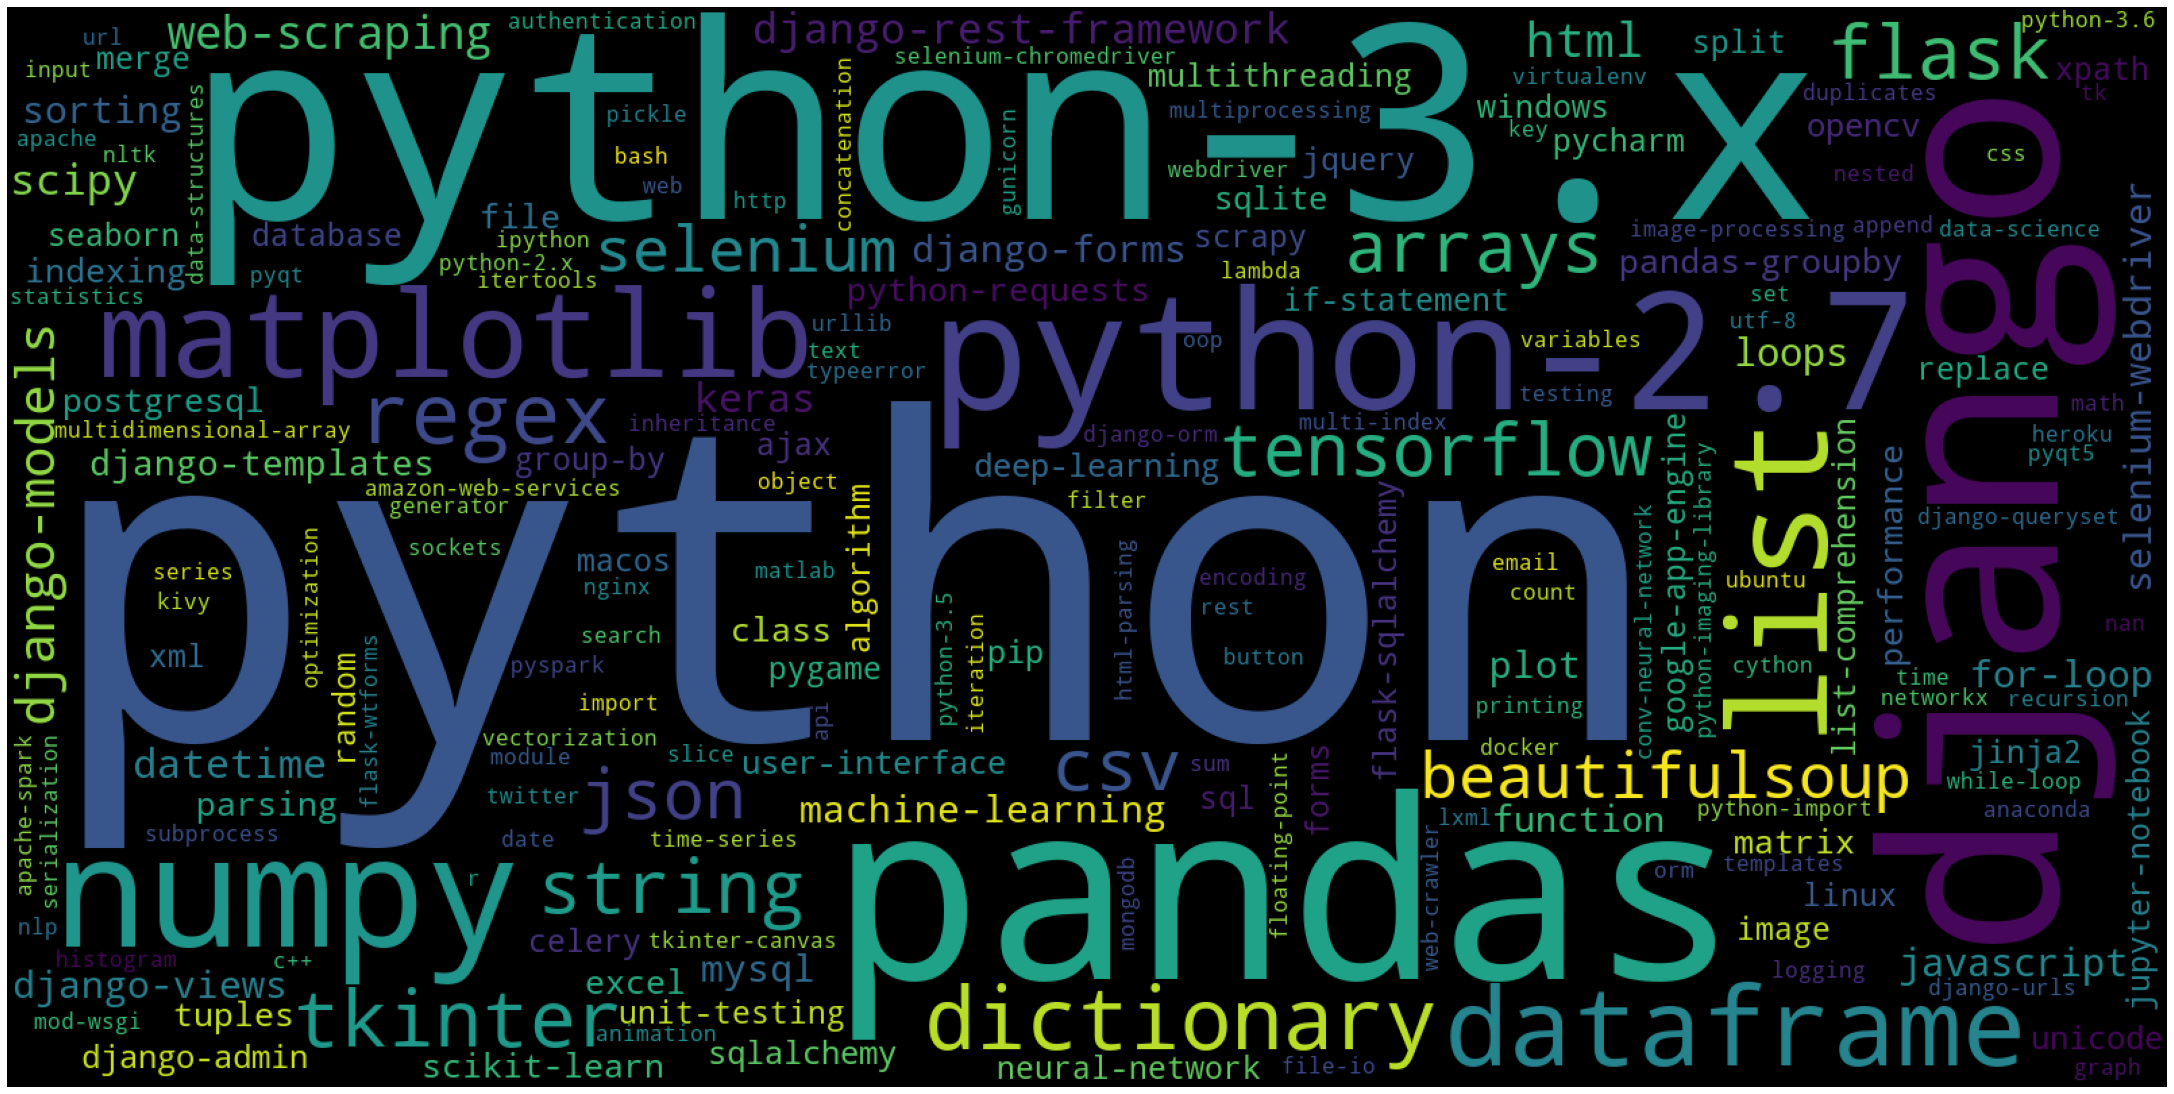

In [4]:
# Visualize all tags based on their frequencies using a WordCloud
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tag_freq_dict)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Although we did filter out a lot of tags in Data processing step, there still exists a lot of "stray" tags which may appear only once or twice as compared to thousands of occurences for other tags. This increases the dimensions of the ground truth data, which is not desirable for our model. Thus we extract the top 500 tags based on their occurences. Given that we have ~140k data points, 500 tags seems to be a good number to experiment with

In [5]:
# Get most common tags
tags_to_use = 500
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]
len(final_tags)

500

we altered the tag data to only include tags from one of these 500 tags, for better model accuracy

In [6]:
# Change tag data to only for final_tags
final_tag_data = []
for tags in data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

**One - hot encode the ground truth data**

Since we are dealing with multi label data, i.e. there are more than one answers for each input, we decided to use the MultiLabelBinarizer from sklearn

For Example If we have total tags as [python, django,flask,nginx], our ground truth of [python, flask] would get converted to [1,0,1,0]

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
tags_encoded.shape

(142765, 500)

In order for our model to understand the raw text data, we need to vectorize it<br>

StackOverflow data is very technical and they use a very specific vocabulary of words, it is not a good idea to use pre-trained WordEmbedding and would not be able to understand the relations between the words in our vocabulary. Thus we decided to train a WordEmbeddings model of my own from scratch.

In [8]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Collect corpus for training word embeddings
documents = [_text.split() for _text in np.array(data.post_corpus)]

In [9]:
data.post_corpus[0]

'create directly executable cross platform gui app using python python works multiple platforms used desktop web applications thus conclude way compile executable mac windows linux also pygtk basically python wrapper gnome toolkit found easier wrap mind around tkinter coming pretty much knowledge gui programming previously works pretty well good tutorials unfortunately nt installer python 26 windows yet may whilefrom appjar import gui num1 def myfcnbtnname global num num 1 winsetlabelmylabel num win guitest winaddbuttonsset myfcn winaddlabelmylabel press button wingo'

In [10]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('data/SO_word2vec_embeddings.bin')

Vocab size 22782


In [11]:
# Load pre-trained embeddings
w2v_model = gensim.models.word2vec.Word2Vec.load('data/SO_word2vec_embeddings.bin')

In [12]:
# Testing Word Embeddings
print('Terms most similar to "django"')
print(w2v_model.wv.most_similar("django"))
print('-'*100)

print('Terms most similar to "api"')
print(w2v_model.wv.most_similar("api"))
print('-'*100)

print('Terms most similar to "gunicorn"')
print(w2v_model.wv.most_similar("gunicorn"))
print('-'*100)

print('Terms most similar to "server"')
print(w2v_model.wv.most_similar("server"))

Terms most similar to "django"
[('flask', 0.5821328163146973), ('mezzanine', 0.5399268865585327), ('wagtail', 0.5262797474861145), ('database', 0.4896438717842102), ('framework', 0.4788367748260498), ('drf', 0.47824329137802124), ('admin', 0.4752196967601776), ('project', 0.47326502203941345), ('app', 0.47167307138442993), ('crud', 0.4557625651359558)]
----------------------------------------------------------------------------------------------------
Terms most similar to "api"
[('apis', 0.5677658319473267), ('webservice', 0.5531613826751709), ('framework', 0.5064548254013062), ('webhook', 0.47390568256378174), ('endpoint', 0.4507259130477905), ('service', 0.4479888081550598), ('application', 0.4375210702419281), ('firebase', 0.4106726050376892), ('oauth', 0.4087442457675934), ('angularjs', 0.4057832658290863)]
----------------------------------------------------------------------------------------------------
Terms most similar to "gunicorn"
[('uwsgi', 0.5714148283004761), ('vps', 0.

In [13]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data.processed_title), tags_encoded, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 114212
TEST size: 28553


In [14]:
# Tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.post_corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# saving
import pickle
with open('data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Using TensorFlow backend.


Found 456086 unique tokens.


In [15]:
# loading tokenizer
import pickle
with open('data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 456086 unique tokens.


In [16]:
# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (114212, 300)


In [17]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(456087, 300)


**Custom loss function**

Since we are dealing with a multilabel classification problem here, we cannot train the model using a binary crossentrophy loss. Thus we used log loss applied on each class separately and then computed it's mean based on the number of classes

In [18]:
import keras.backend as K

# Custom loss function to handle multilabel classification task
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [20]:
# Build Model
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units = 10000,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )  
model.add(Dropout(0.35))
model.add(Dense(units = 1150,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dropout(0.25))
model.add(Dense(units = 750,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dense(500, activation='sigmoid'))

model.summary()

model.compile(loss=multitask_loss,
              optimizer="adam")
              
# Train Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 256
history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=15,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# Save model
model.save('data/Tag_predictor.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          136826100 
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               1602000   
_________________________________________________________________
dense_5 (Dense)              (None, 10000)             5010000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1150)              11501150  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1150)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 750)              

e:\dev\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


102790/102790 [==============================] - 131s 1ms/step - loss: 6.4126 - val_loss: 6.0560
Epoch 3/15
102790/102790 [==============================] - 132s 1ms/step - loss: 5.9834 - val_loss: 5.7902
Epoch 4/15
102790/102790 [==============================] - 140s 1ms/step - loss: 5.7109 - val_loss: 5.6131
Epoch 5/15
102790/102790 [==============================] - 132s 1ms/step - loss: 5.5142 - val_loss: 5.5313
Epoch 6/15
102790/102790 [==============================] - 131s 1ms/step - loss: 5.3452 - val_loss: 5.5680
Epoch 7/15
102790/102790 [==============================] - 130s 1ms/step - loss: 5.1984 - val_loss: 5.4571
Epoch 8/15
102790/102790 [==============================] - 131s 1ms/step - loss: 5.0659 - val_loss: 5.4748
Epoch 9/15
102790/102790 [==============================] - 132s 1ms/step - loss: 4.9420 - val_loss: 5.4878
Epoch 10/15
102790/102790 [==============================] - 132s 1ms/step - loss: 4.8285 - val_loss: 5.5269
Epoch 11/15
102790/102790 [===========

In [21]:
def predict_tags(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    prediction = model.predict([x_test])[0]
    for i,value in enumerate(prediction):
        if value > 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [22]:
test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: execute python django runserver command jupyter notebook
----------------------------------------------------------------------------------------------------
Predicted: [('django', 'python')]
Ground Truth: [('django', 'jupyter-notebook', 'python')]


Test Case: extract words documents docx transform csv clustering
----------------------------------------------------------------------------------------------------
Predicted: [('csv', 'pandas', 'python')]
Ground Truth: [('csv', 'python')]


Test Case: change python version terminal intellij
----------------------------------------------------------------------------------------------------
Predicted: [('python', 'python-3.x')]
Ground Truth: [('python', 'python-2.7')]


Test Case: optimizing python code filtering numpy arrays
----------------------------------------------------------------------------------------------------
Predicted: [('arrays', 'numpy', 'python')]
Ground Truth: [('arrays', 'coordinates', 'numpy', 'python')]


**Test the prediction function**

In [23]:
predict_tags("how to scrape google using python")

[('beautifulsoup', 'python', 'web-scraping')]